# Init

In [1]:
import os

path = os.getcwd()
# set the working directory
os.chdir('c:\\Github\\new-peak-project\\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
new_path = config["NEW_DATA_PATH"]
print(f'New data path set to: {new_path}')

New data path set to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project


# Config

In [4]:
from models.utils.config_manager import initialise_config

initialise_config(folder_name="model-inspection", verbose=1)


Folder I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection already exists. No changes made.


In [5]:
# or load existing config
from models.utils.config_manager import load_configs, print_config

loaded_config = load_configs(folder_name="model-inspection", config_suffix="testCaseA")
print_config(loaded_config)

notebook: 
  version: testCaseA
  name: model-inspection
  compatible_notebooks: ['model-inspection-1']
  desc: Monitor the behaviour of basic networks to ensure systems correctness 

exp: 
  spec: 
    n_layers: 2
    n_cascades: 1
    n_regs: 0
    gen_seed: 42
    drug: 
      name: D
      start: 500
      dose: 500
      regulations: [['R1', 'down']]
  parameter_generation: 
    ic_range: [200, 1000]
    param_range: [0.5, 1.5]
    param_mul_range: [0.99, 1.01]
  simulation: 
    start: 0
    stop: 1000
    step: 100


# Run

In [6]:
from models.Specs.ModelSpec3 import ModelSpec3

notebook_config = loaded_config["notebook"]
exp_config = loaded_config["exp"]
spec_config = exp_config['spec']
n_layers = spec_config['n_layers']
new_spec = ModelSpec3(num_intermediate_layers=n_layers)


In [7]:
import logging
from models.Specs.Drug import Drug
logging.basicConfig(level=logging.INFO)


drug_config = spec_config['drug']
drug_name = drug_config['name']
drug_start = drug_config['start']
drug_dose = drug_config['dose']
drug_regulations = drug_config['regulations']

new_drug = Drug(name=drug_name, start_time=drug_start, default_value=drug_dose)
for regs in drug_regulations:
    target, type = regs[0], regs[1]
    new_drug.add_regulation(target, type)

n_cascades = spec_config['n_cascades']
n_regs = spec_config['n_regs']
seed = spec_config['gen_seed']    
    
new_spec.generate_specifications(n_cascades, n_regs, seed)
new_spec.add_drug(new_drug)

In [8]:
param_gen_config = exp_config['parameter_generation']
specie_range = param_gen_config['ic_range']
param_range = param_gen_config['param_range']
param_mul_range = param_gen_config['param_mul_range']
builder = new_spec.generate_network('test', specie_range, param_range, param_mul_range, seed)

INFO:models.Specs.ModelSpec3:Generated model test with 8 reactions.
INFO:models.Specs.ModelSpec3:Model States: 8
INFO:models.Specs.ModelSpec3:Model Parameters: 20
INFO:models.Specs.ModelSpec3:Model Reactions: 8


In [13]:
from models.Solver.RoadrunnerSolver import RoadrunnerSolver
from models.utils.config_manager import save_data
sim_config = exp_config['simulation']
sim_start = sim_config['start']
sim_stop = sim_config['stop']
sim_step = sim_config['step']
solver = RoadrunnerSolver()
solver.compile(builder.get_sbml_model())
res = solver.simulate(sim_start, sim_stop, sim_step)

save_data(notebook_config, res, "simulation_data")

save_data(notebook_config, res, "simulation_data", "csv", verbose=1)

Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection\figures\testCaseA_simulation_plot.png


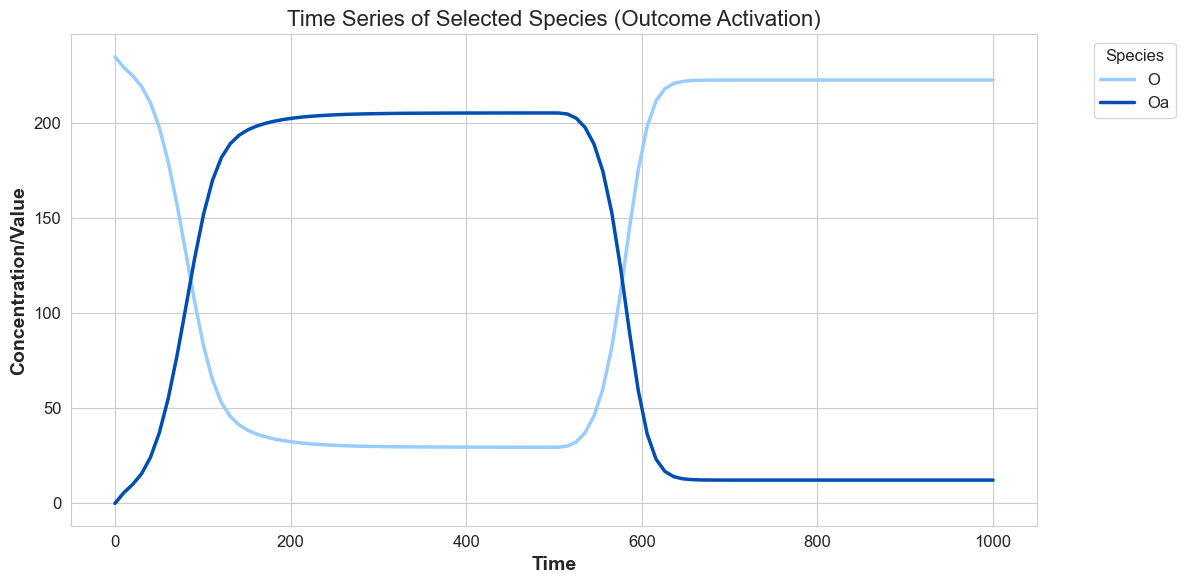

In [10]:
from visual.simulation import visualise_simulation
from models.utils.config_manager import save_figure

figure = visualise_simulation(res, activated_only=True, outcome_activation=True, show_legend=True)
save_figure(notebook_config, figure, "simulation_plot", "png", verbose=1, dpi=300)

Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection\figures\testCaseA_network_topology.png


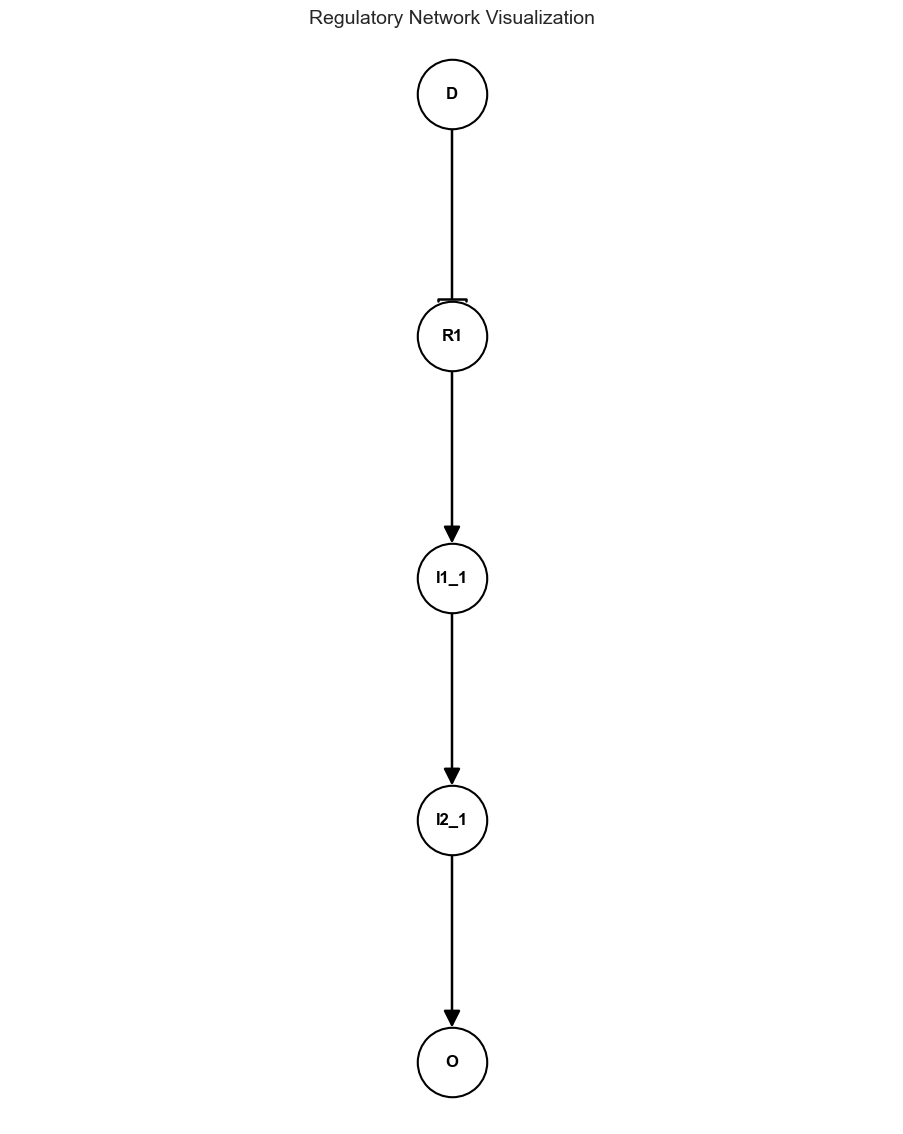

In [11]:
from visual.network_topology import visualise_network_2, create_layers

# num_intermediate_layers=2, num_cascades=3, drugs=['D']

layers = create_layers(n_layers, n_cascades, [drug_name])
regulations = new_spec.get_regulations()
feedback_regulations = new_spec.get_feedback_regulations()
figure = visualise_network_2(layers, regulations, feedback_regulations=feedback_regulations)
save_figure(notebook_config, figure, "network_topology", "png", verbose=1, dpi=300)